In [1]:
import torch
import torch.nn.functional as F
import csv
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [2]:
# https://www.geo.fu-berlin.de/en/v/soga/Basics-of-statistics/Continous-Random-Variables/The-Standard-Normal-Distribution/The-Standard-Normal-Distribution-An-Example/index.html
# https://userpage.fu-berlin.de/soga/200/2010_data_sets/students.csv
p = '/app/Contrastive-Learning-Benchmarking//data/students.csv'

In [3]:
with open(p, 'r') as file:
    my_reader = csv.reader(file, delimiter=',')
    rows = [r for r in my_reader]

In [4]:
rows

[['stud.id',
  'name',
  'gender',
  'age',
  'height',
  'weight',
  'religion',
  'nc.score',
  'semester',
  'major',
  'minor',
  'score1',
  'score2',
  'online.tutorial',
  'graduated',
  'salary'],
 ['1',
  '833917',
  'Gonzales, Christina',
  'Female',
  '19',
  '160',
  '64.8',
  'Muslim',
  '1.91',
  '1st',
  'Political Science',
  'Social Sciences',
  'NA',
  'NA',
  '0',
  '0',
  'NA'],
 ['2',
  '898539',
  "Lozano, T'Hani",
  'Female',
  '19',
  '172',
  '73',
  'Other',
  '1.56',
  '2nd',
  'Social Sciences',
  'Mathematics and Statistics',
  'NA',
  'NA',
  '0',
  '0',
  'NA'],
 ['3',
  '379678',
  'Williams, Hanh',
  'Female',
  '22',
  '168',
  '70.6',
  'Protestant',
  '1.24',
  '3rd',
  'Social Sciences',
  'Mathematics and Statistics',
  '45',
  '46',
  '0',
  '0',
  'NA'],
 ['4',
  '807564',
  'Nem, Denzel',
  'Male',
  '19',
  '183',
  '79.7',
  'Other',
  '1.37',
  '2nd',
  'Environmental Sciences',
  'Mathematics and Statistics',
  'NA',
  'NA',
  '0',
  '0',
  

In [5]:
height = [int(float(r[rows[0].index('height')+1])) for r in rows[1:]]
weight = [int(float(r[rows[0].index('weight')+1])) for r in rows[1:]]
# religion = [r[rows[0].index('religion')+1] for r in rows[1:]]
# ncscore = [float(r[rows[0].index('nc.score')+1]) for r in rows[1:]]

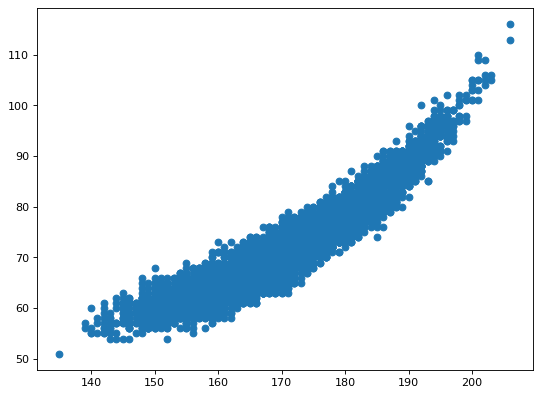

In [6]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(height, weight)

In [7]:
max(height), min(height)

(206, 135)

In [8]:
max(weight), min(weight)

(116, 51)

In [9]:
# x axis -- height -- 135-206
# y axis -- weight -- 51-116
count_table = np.zeros((206-135+1, 116-51+1))

for h, w in zip(height, weight):
    count_table[int(h)-135,int(w)-51] += 1
 

xy = count_table/np.sum(count_table) + 0.00001
xy = xy/np.sum(xy)
xy.shape

(72, 66)

In [10]:
np.sum(count_table)

8239.0

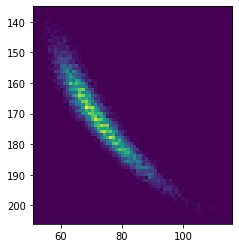

In [11]:
plt.imshow(xy, extent=[51,116, 206,135])

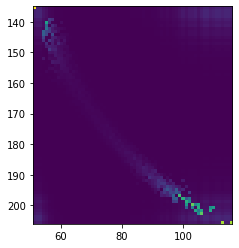

In [12]:
x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]
plt.imshow(xy/xyind, extent=[51,116, 206,135])

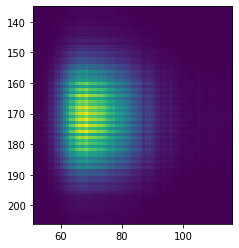

In [13]:
plt.imshow(xyind, extent=[51,116, 206,135])

In [12]:
def run_expr4(n_batch, iters):
    '''
    model pxy directly
    '''
    torch.manual_seed(42)
    
    M = torch.randn(xy.shape, requires_grad = True, device='cuda')
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}

    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(xi//x.shape[0], xi%x.shape[0]) for xi in samples])
#         import pdb; pdb.set_trace()
        
        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi = F[samples[i,0],samples[i,1]]/torch.sum(F[:,:])
            loss = loss + torch.log(lossi) 
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 1000 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy(), extent=[51,116, 206,135])
            plt.savefig(f"students_training_results/Mbar_joint_{n_batch}_{iteration}.png")

    np.save(f'students_training_results/Mbar_joint_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'students_training_results/M_joint_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'students_training_results/training_loss_joint_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 0/9999 [00:00<?, ?it/s]

tensor([ 0.1940,  2.1614, -0.1721,  0.8491, -1.9244], device='cuda:0',
       grad_fn=<SliceBackward>)


 10%|█         | 1000/9999 [04:51<45:47,  3.28it/s]

tensor(2.8487, device='cuda:0', grad_fn=<VarBackward0>)


 20%|██        | 2000/9999 [09:46<40:11,  3.32it/s]

tensor(2.7733, device='cuda:0', grad_fn=<VarBackward0>)


 30%|███       | 3000/9999 [14:53<37:32,  3.11it/s]

tensor(2.7499, device='cuda:0', grad_fn=<VarBackward0>)


 40%|████      | 4000/9999 [20:10<33:38,  2.97it/s]

tensor(2.7027, device='cuda:0', grad_fn=<VarBackward0>)


 50%|█████     | 5000/9999 [25:16<24:07,  3.45it/s]

tensor(2.6855, device='cuda:0', grad_fn=<VarBackward0>)


 60%|██████    | 6000/9999 [30:04<19:44,  3.38it/s]

tensor(2.7149, device='cuda:0', grad_fn=<VarBackward0>)


 70%|███████   | 7000/9999 [34:51<15:01,  3.33it/s]

tensor(2.7061, device='cuda:0', grad_fn=<VarBackward0>)


 80%|████████  | 8000/9999 [39:52<10:34,  3.15it/s]

tensor(2.7003, device='cuda:0', grad_fn=<VarBackward0>)


 90%|█████████ | 9000/9999 [45:02<05:27,  3.05it/s]

tensor(2.7206, device='cuda:0', grad_fn=<VarBackward0>)


100%|██████████| 9999/9999 [50:19<00:00,  3.31it/s]


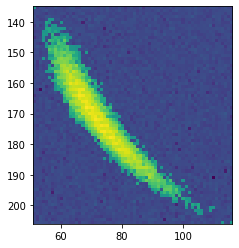

In [13]:
# model pxy directly
M, Mbar, history = run_expr4(n_batch=500, iters=10000)

In [37]:
Mbar_joint = torch.from_numpy(np.load(f'students_training_results/Mbar_joint_{500}_{9999}.npy'))
M_joint = torch.from_numpy(np.load(f'students_training_results/M_joint_{500}_{9999}.npy'))
loss_joint = np.load(f'students_training_results/training_loss_joint_{500}_{9999}.npy')

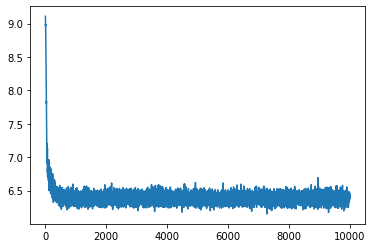

In [38]:
plt.plot(loss_joint)

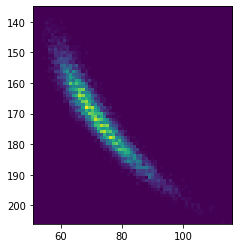

In [22]:
plt.imshow(torch.exp(Mbar_joint), extent=[51,116, 206,135])

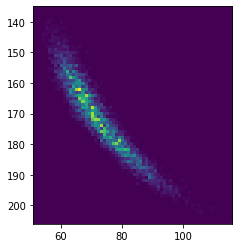

In [23]:
plt.imshow(torch.exp(M_joint), extent=[51,116, 206,135])

In [26]:
# Compare Mbar with xy
F_joint = torch.exp(Mbar_joint)
F_joint_normalized = F_joint/torch.sum(F_joint)
log_F_joint_normalized = torch.log(F_joint_normalized)

F.kl_div(log_F_joint_normalized, torch.from_numpy(xy))

/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(1.4273e-07, dtype=torch.float64)

In [14]:
def run_expr5(n_batch, iters):
    '''
    model x|y and y|x
    '''
    torch.manual_seed(42)
    
    M = torch.randn(xy.shape, requires_grad = True, device='cuda')
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}

    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(xi//x.shape[0], xi%x.shape[0]) for xi in samples])
#         import pdb; pdb.set_trace()
        
        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi_x = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], range(xy.shape[1])])
            lossi_y = F[samples[i,0],samples[i,1]]/torch.sum(F[range(xy.shape[0]), samples[i,1]])

            loss = loss + ((torch.log(lossi_x) + torch.log(lossi_y)) * 0.5)
            
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 1000 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy(), extent=[51,116, 206,135])
            plt.savefig(f"students_training_results/Mbar_pseudo_{n_batch}_{iteration}.png")

    np.save(f'students_training_results/Mbar_pseudo_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'students_training_results/M_pseudo_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'students_training_results/training_loss_pseudo_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 0/9999 [00:00<?, ?it/s]

tensor([ 0.1940,  2.1614, -0.1721,  0.8491, -1.9244], device='cuda:0',
       grad_fn=<SliceBackward>)


 10%|█         | 1000/9999 [07:53<1:14:22,  2.02it/s]

tensor(3.0292, device='cuda:0', grad_fn=<VarBackward0>)


 20%|██        | 2000/9999 [16:04<1:08:21,  1.95it/s]

tensor(2.7819, device='cuda:0', grad_fn=<VarBackward0>)


 30%|███       | 3000/9999 [24:27<1:01:23,  1.90it/s]

tensor(2.6938, device='cuda:0', grad_fn=<VarBackward0>)


 40%|████      | 4000/9999 [32:24<50:31,  1.98it/s]  

tensor(2.7224, device='cuda:0', grad_fn=<VarBackward0>)


 50%|█████     | 5000/9999 [40:16<41:07,  2.03it/s]

tensor(2.7203, device='cuda:0', grad_fn=<VarBackward0>)


 60%|██████    | 6000/9999 [48:11<33:42,  1.98it/s]

tensor(2.6963, device='cuda:0', grad_fn=<VarBackward0>)


 70%|███████   | 7000/9999 [56:20<26:04,  1.92it/s]

tensor(2.7038, device='cuda:0', grad_fn=<VarBackward0>)


 80%|████████  | 8000/9999 [1:04:42<17:47,  1.87it/s]

tensor(2.7191, device='cuda:0', grad_fn=<VarBackward0>)


 90%|█████████ | 9000/9999 [1:13:09<08:48,  1.89it/s]

tensor(2.7190, device='cuda:0', grad_fn=<VarBackward0>)


100%|██████████| 9999/9999 [1:21:02<00:00,  2.06it/s]


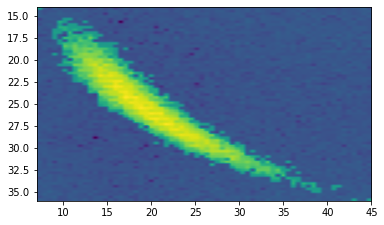

In [15]:
# model pxy directly
M, Mbar, history = run_expr5(n_batch=500, iters=10000)

In [41]:
Mbar_pseudo = torch.from_numpy(np.load(f'students_training_results/Mbar_pseudo_{500}_{9999}.npy'))
M_pseudo = torch.from_numpy(np.load(f'students_training_results/M_pseudo_{500}_{9999}.npy'))
loss_pseudo = np.load(f'students_training_results/training_loss_pseudo_{500}_{9999}.npy')

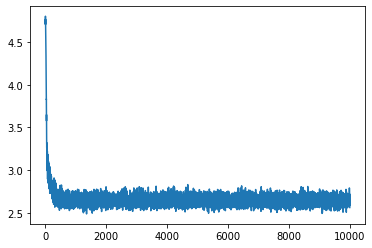

In [42]:
plt.plot(loss_pseudo)

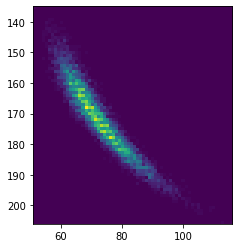

In [28]:
plt.imshow(torch.exp(Mbar_pseudo), extent=[51,116, 206,135])

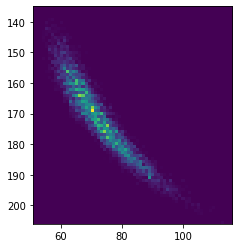

In [29]:
plt.imshow(torch.exp(M_pseudo), extent=[51,116, 206,135])

In [30]:
# Compare Mbar with xy
F_pseudo = torch.exp(Mbar_pseudo)
F_pseudo_normalized = F_pseudo/torch.sum(F_pseudo)
log_F_pseudo_normalized = torch.log(F_pseudo_normalized)

F.kl_div(log_F_pseudo_normalized, torch.from_numpy(xy))

tensor(1.8072e-07, dtype=torch.float64)

In [16]:
def run_expr(n_batch, iters):
    '''
    info NCE
    '''
    torch.manual_seed(42)
    
    M = torch.randn(xy.shape, requires_grad = True, device='cuda')
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}

    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(xi//x.shape[0], xi%x.shape[0]) for xi in samples])
#         import pdb; pdb.set_trace()
        
        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
#             lossi = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], samples[:,1]])
            
            lossi_x = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], samples[:,1]])
            lossi_y = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[:,0], samples[i,1]])
            
            loss = loss + ((torch.log(lossi_x) + torch.log(lossi_y)) * 0.5)
            
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 1000 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy(), extent=[51,116, 206,135])
            plt.savefig(f"students_training_results/Mbar_infoNCE_{n_batch}_{iteration}.png")

    np.save(f'students_training_results/Mbar_infoNCE_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'students_training_results/M_infoNCE_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'students_training_results/training_loss_infoNCE_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 0/9999 [00:00<?, ?it/s]

tensor([ 0.1940,  2.1614, -0.1721,  0.8491, -1.9244], device='cuda:0',
       grad_fn=<SliceBackward>)


 10%|█         | 1000/9999 [07:57<1:15:44,  1.98it/s]

tensor(2.8412, device='cuda:0', grad_fn=<VarBackward0>)


 20%|██        | 2000/9999 [15:54<1:06:25,  2.01it/s]

tensor(3.0099, device='cuda:0', grad_fn=<VarBackward0>)


 30%|███       | 3000/9999 [23:50<57:47,  2.02it/s]  

tensor(3.3191, device='cuda:0', grad_fn=<VarBackward0>)


 40%|████      | 4000/9999 [31:45<50:15,  1.99it/s]

tensor(3.5965, device='cuda:0', grad_fn=<VarBackward0>)


 50%|█████     | 5000/9999 [39:42<41:57,  1.99it/s]

tensor(3.8951, device='cuda:0', grad_fn=<VarBackward0>)


 60%|██████    | 6000/9999 [47:38<33:36,  1.98it/s]

tensor(4.0572, device='cuda:0', grad_fn=<VarBackward0>)


 70%|███████   | 7000/9999 [55:44<25:52,  1.93it/s]

tensor(4.1705, device='cuda:0', grad_fn=<VarBackward0>)


 80%|████████  | 8000/9999 [1:04:02<17:49,  1.87it/s]

tensor(4.2612, device='cuda:0', grad_fn=<VarBackward0>)


 90%|█████████ | 9000/9999 [1:12:30<09:07,  1.83it/s]

tensor(4.3165, device='cuda:0', grad_fn=<VarBackward0>)


100%|██████████| 9999/9999 [1:20:40<00:00,  2.07it/s]


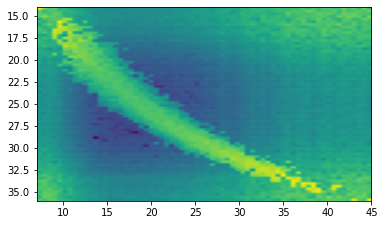

In [17]:
# info NCE both directions
M, Mbar, history = run_expr(n_batch=500, iters=10000)

In [44]:
Mbar_infoNCE = torch.from_numpy(np.load(f'students_training_results/Mbar_infoNCE_{500}_{9999}.npy'))
M_infoNCE = torch.from_numpy(np.load(f'students_training_results/M_infoNCE_{500}_{9999}.npy'))
loss_infoNCE = np.load(f'students_training_results/training_loss_infoNCE_{500}_{9999}.npy')

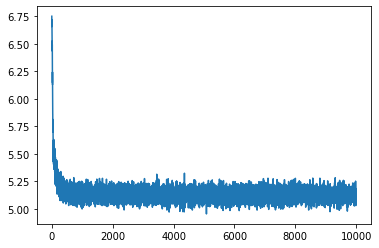

In [45]:
plt.plot(loss_infoNCE)

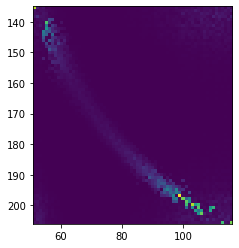

In [32]:
plt.imshow(torch.exp(Mbar_infoNCE), extent=[51,116, 206,135])

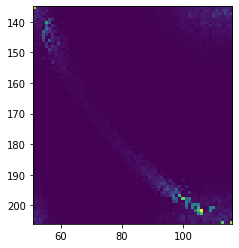

In [33]:
plt.imshow(torch.exp(M_infoNCE), extent=[51,116, 206,135])

In [34]:
# Compare Mbar with xy
F_infoNCE = torch.exp(Mbar_infoNCE)
F_infoNCE_normalized = F_infoNCE/torch.sum(F_infoNCE)
log_F_infoNCE_normalized = torch.log(F_infoNCE_normalized)

F.kl_div(log_F_infoNCE_normalized, torch.from_numpy(xy))

tensor(0.0003, dtype=torch.float64)